In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dprasannavenkatesh","key":"09a552d9b412718c3ecdece5322d84b4"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
!pip install -q kaggle


In [4]:
!kaggle datasets download dprasannavenkatesh/bone-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/dprasannavenkatesh/bone-mri-dataset
License(s): unknown
100% 1.05G/1.05G [00:12<00:00, 213MB/s]
100% 1.05G/1.05G [00:12<00:00, 87.5MB/s]


In [5]:
!unzip -q bone-mri-dataset.zip

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
import pandas as pd
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split


source_dir = "/content/Data"
base_dir = "data_split"


for split in ['train', 'val', 'test']:
    for category in ['Fractured', 'Not Fractured']:
        os.makedirs(os.path.join(base_dir, split, category), exist_ok=True)


def split_data(category):
    path = os.path.join(source_dir, category)
    images = os.listdir(path)


    train_files, temp_files = train_test_split(images, test_size=0.3, random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

  
    def copy_files(files, split):
        for f in files:
            src = os.path.join(path, f)
            dst = os.path.join(base_dir, split, category, f)
            shutil.copy(src, dst)


    copy_files(train_files, "train")
    copy_files(val_files, "val")
    copy_files(test_files, "test")


split_data("Fractured")
split_data("Not Fractured")

print(" Dataset successfully split into train, val, and test folders!")


Detected classes: ['Fractured', 'Not Fractured']


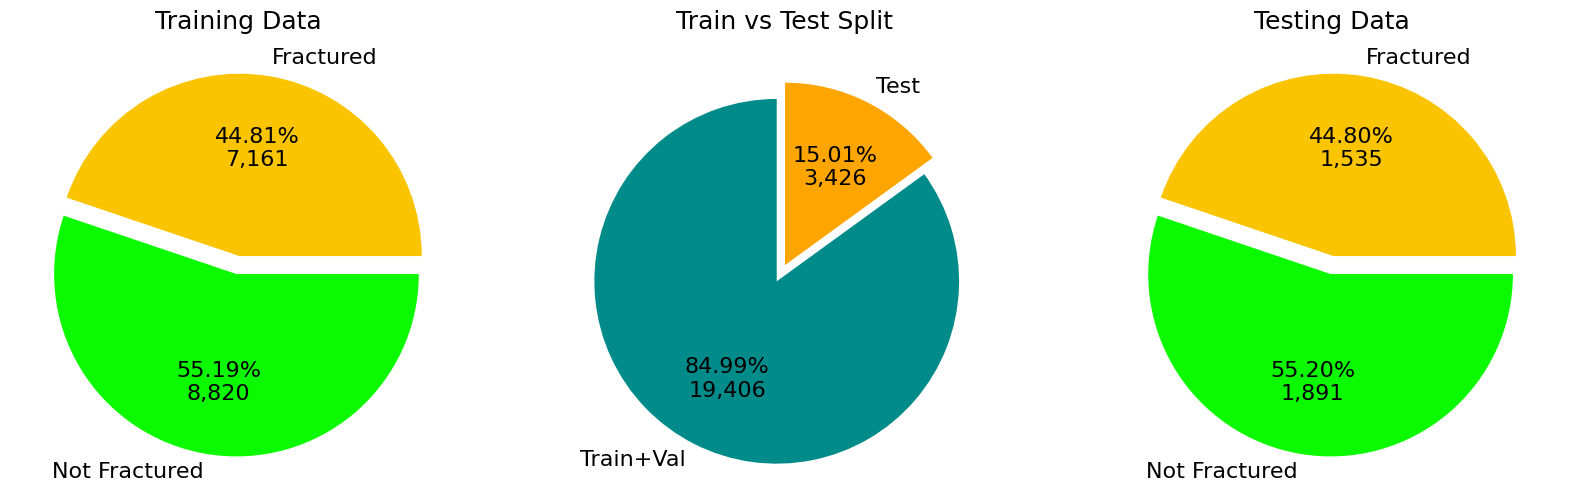

In [ ]:
import os
import matplotlib.pyplot as plt


base_dir = "/content/data_split"  


class_names = sorted(os.listdir(os.path.join(base_dir, "train")))
print("Detected classes:", class_names)

def count_images(split):
    split_counts = []
    for c in class_names:
        path = os.path.join(base_dir, split, c)
        count = len(os.listdir(path))
        split_counts.append(count)
    return split_counts


train_counts = count_images("train")
val_counts = count_images("val")
test_counts = count_images("test")


train_total = sum(train_counts)
val_total = sum(val_counts)
test_total = sum(test_counts)
split_totals = [train_total + val_total, test_total]


fig, ax = plt.subplots(ncols=3, figsize=(20, 10))


ax[0].set_title('Training Data', fontsize=18)
ax[0].pie(
    train_counts,
    labels=class_names,
    colors=['#FAC500','#0BFA00'],
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(train_counts) / 100),
    explode=(0.05, 0.05),
    textprops={'fontsize': 16}
)


ax[1].set_title('Train vs Test Split', fontsize=18)
ax[1].pie(
    split_totals,
    labels=['Train+Val', 'Test'],
    colors=['darkcyan', 'orange'],
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(split_totals) / 100),
    explode=(0.1, 0),
    startangle=90,
    textprops={'fontsize': 16}
)


ax[2].set_title('Testing Data', fontsize=18)
ax[2].pie(
    test_counts,
    labels=class_names,
    colors=['#FAC500','#0BFA00'],
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(test_counts) / 100),
    explode=(0.05, 0.05),
    textprops={'fontsize': 16}
)

plt.show()


In [9]:
train_dir = '/content/data_split/train'
test_dir = '/content/data_split/test'
val_dir = '/content/data_split/val'

In [10]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [11]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                              image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              batch_size=BATCH_SIZE)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                              image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              batch_size=BATCH_SIZE)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(val_dir,
                                                              image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              batch_size=BATCH_SIZE)

Found 15981 files belonging to 2 classes.
Found 3426 files belonging to 2 classes.
Found 3425 files belonging to 2 classes.


In [12]:
class_names = train_ds.class_names
class_names

['Fractured', 'Not Fractured']

In [13]:
class_names = train_ds.class_names

def show_images(dataset, title):
    plt.figure(figsize=(6, 6))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i+1)
            plt.imshow(images[i].numpy().astype('uint8'))
            plt.title(class_names[labels[i]])
            plt.axis('off')
    plt.suptitle(title)
    plt.show()


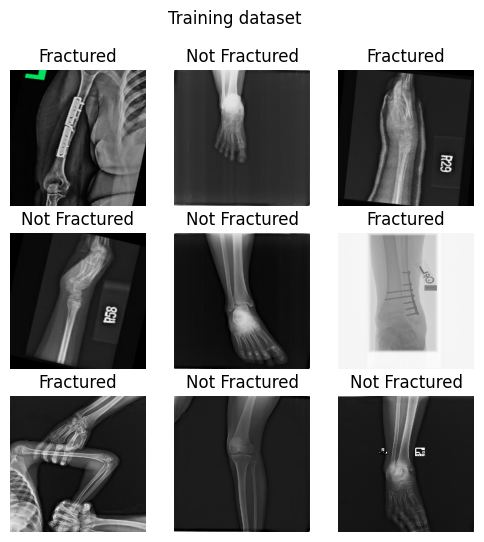

In [14]:
show_images(train_ds, 'Training dataset')

In [15]:
from pathlib import Path

In [16]:
def count_classes(dataset, class_name):
    dataset_path = Path(dataset)
    return len(list(dataset_path.glob(f"{class_name}/*")))

def create_class_counts_df(dataset, class_names):
    counts = {'class': [], 'count': []}
    for class_name in class_names:
        counts['class'].append(class_name)
        counts['count'].append(count_classes(dataset, class_name))
    return pd.DataFrame(counts)

def plot_class_distribution(df, title, palette="viridis"):
    sns.barplot(x='class', y='count', data=df, palette=palette)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

def plot_class_pie_chart(df, title):
    plt.pie(df['count'], labels=df['class'], autopct='%1.1f%%', startangle=90, colors=sns.color_palette('viridis', len(df)))
    plt.title(title)
    plt.axis('equal')
    plt.show()

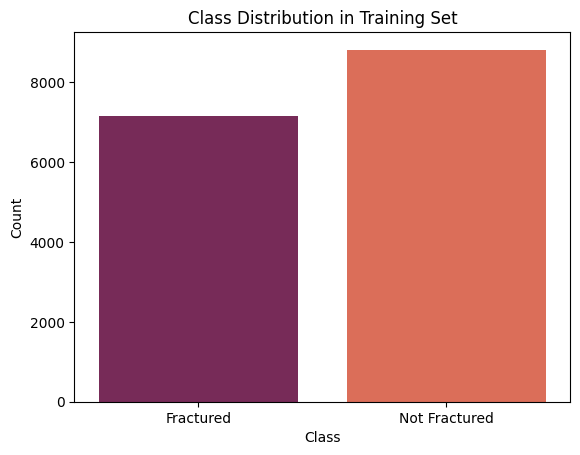

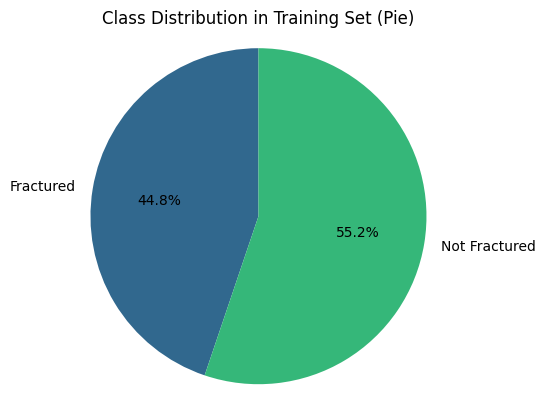

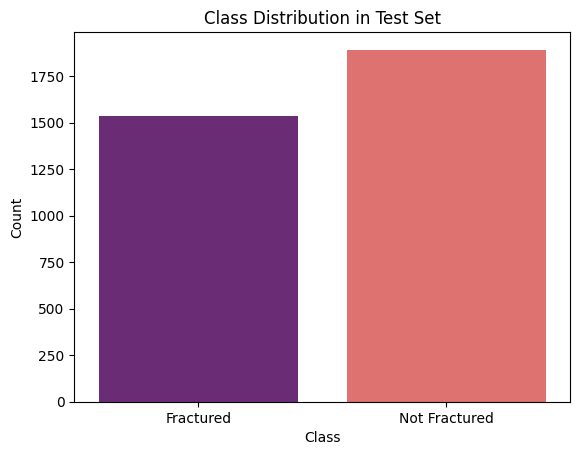

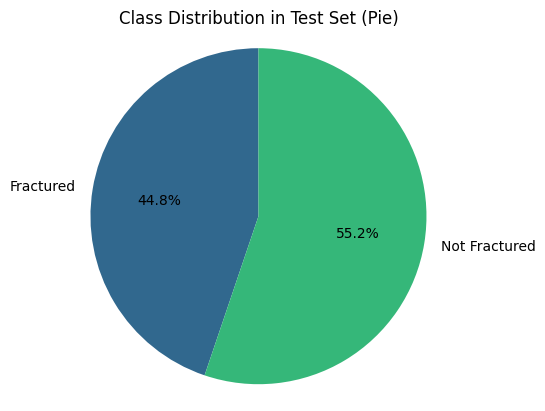

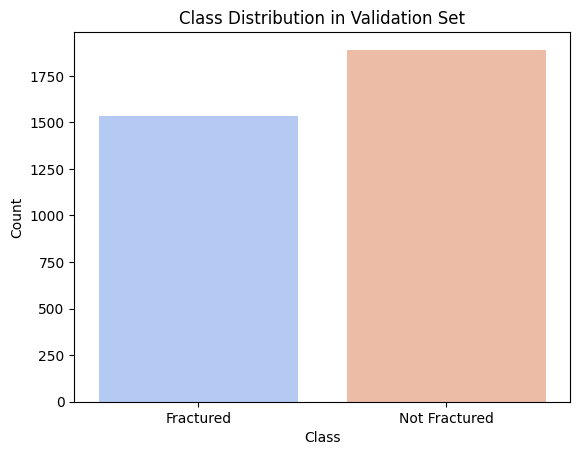

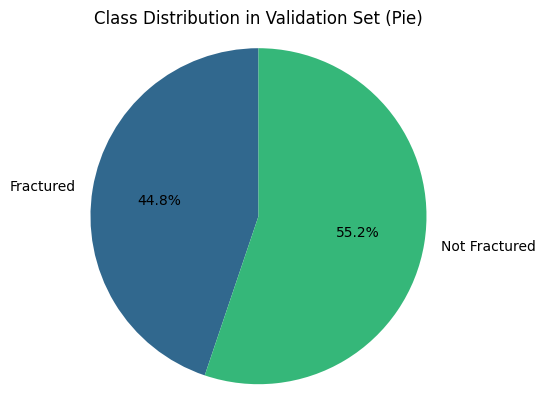

In [17]:
class_names = ['Fractured', 'Not Fractured']

train_df = create_class_counts_df(train_dir, class_names)
test_df = create_class_counts_df(test_dir, class_names)
val_df = create_class_counts_df(val_dir, class_names)

plot_class_distribution(train_df, 'Class Distribution in Training Set', palette='rocket')
plot_class_pie_chart(train_df, 'Class Distribution in Training Set (Pie)')

plot_class_distribution(test_df, 'Class Distribution in Test Set', palette='magma')
plot_class_pie_chart(test_df, 'Class Distribution in Test Set (Pie)')

plot_class_distribution(val_df, 'Class Distribution in Validation Set', palette='coolwarm')
plot_class_pie_chart(val_df, 'Class Distribution in Validation Set (Pie)')

In [18]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [19]:
training_set = train_datagen.flow_from_directory(train_dir,
                                                target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                batch_size=32,
                                                color_mode='grayscale', # Added for grayscale
                                                class_mode='binary')

Found 15981 images belonging to 2 classes.


In [20]:
test_set = train_datagen.flow_from_directory(test_dir,
                                                target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                batch_size=32,
                                                color_mode='grayscale', # Added for grayscale
                                                class_mode='binary')

Found 3426 images belonging to 2 classes.


In [21]:
val_set = train_datagen.flow_from_directory(val_dir,
                                                target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                batch_size=32,
                                                color_mode='grayscale', # Added for grayscale
                                                class_mode='binary')

Found 3425 images belonging to 2 classes.


In [29]:
model = models.Sequential([
    layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,168,513 (42.60 MB)

 Trainable params: 11,168,513 (42.60 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

GPU is available


In [31]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [32]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [33]:
tf.debugging.set_log_device_placement(True)

In [34]:
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [35]:
history = model.fit(training_set,
                    validation_data=val_set,
                    epochs=30,
                    batch_size=BATCH_SIZE)

Epoch 1/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 134s 252ms/step - accuracy: 0.6586 - loss: 0.6249 - val_accuracy: 0.7518 - val_loss: 0.5139
Epoch 2/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 119s 239ms/step - accuracy: 0.7725 - loss: 0.4803 - val_accuracy: 0.8307 - val_loss: 0.3942
Epoch 3/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 121s 241ms/step - accuracy: 0.8504 - loss: 0.3599 - val_accuracy: 0.8730 - val_loss: 0.3248
Epoch 4/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 120s 241ms/step - accuracy: 0.8911 - loss: 0.2729 - val_accuracy: 0.8873 - val_loss: 0.2930
Epoch 5/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 121s 241ms/step - accuracy: 0.9181 - loss: 0.2153 - val_accuracy: 0.9147 - val_loss: 0.2215
Epoch 6/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 120s 240ms/step - accuracy: 0.9341 - loss: 0.1751 - val_accuracy: 0.9267 - val_loss: 0.2041
Epoch 7/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 120s 239ms/step - accuracy: 0.9427 - loss: 0.1518 - val_accuracy: 0.9264 - val_loss: 0.2034
Epoch 8/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 121s 241ms/step - accuracy: 0.9506 -

In [36]:
test_loss, test_acc = model.evaluate(test_set)
print(f"Test Accuracy: {test_acc:.2f}")
print(f"Test Loss: {test_loss:.2f}")

108/108 ━━━━━━━━━━━━━━━━━━━━ 21s 193ms/step - accuracy: 0.9527 - loss: 0.2249
Test Accuracy: 0.95
Test Loss: 0.20


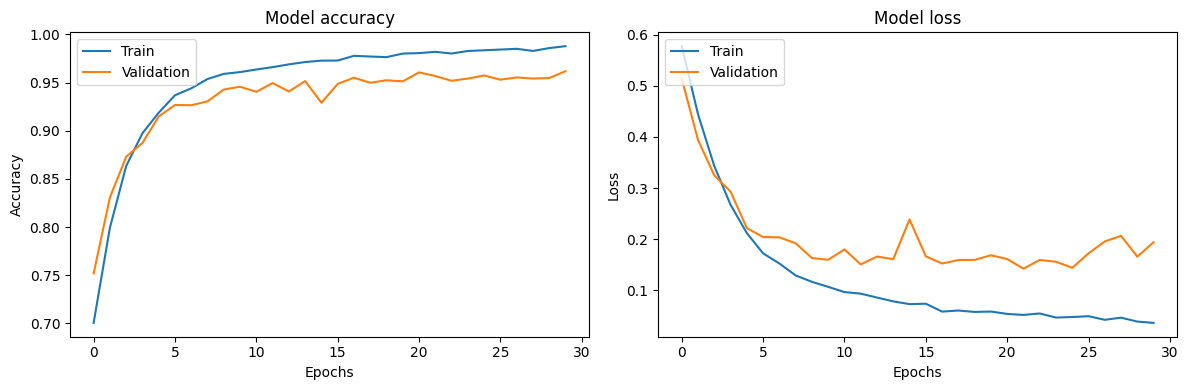

In [37]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [38]:
model.save('bone_fracture_model.keras')
print("Model saved in .keras format")

Model saved in .keras format


In [ ]:

from tensorflow.keras.models import load_model
loaded_model = load_model('bone_fracture_model.keras')
print("Model loaded successfully.")

Model loaded successfully.


In [40]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  uploaded_image_path = fn

Saving bone-fracture-in-x-ray.jpg to bone-fracture-in-x-ray.jpg
User uploaded file "bone-fracture-in-x-ray.jpg" with length 39811 bytes


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np


img = image.load_img(uploaded_image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
img = img.convert('L')
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

img_array = np.expand_dims(img_array, axis=-1)
img_array /= 255.0 

print("Image preprocessed successfully.")

Image preprocessed successfully.


In [ ]:

prediction = loaded_model.predict(img_array)
print(f"Raw prediction output: {prediction}")


if prediction[0][0] > 0.5:
    prediction_label = 'Not Fractured'
    confidence = prediction[0][0]
else:
    prediction_label = 'Fractured'
    confidence = 1 - prediction[0][0]

print(f"The model predicts: {prediction_label} with a confidence of {confidence:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
Raw prediction output: [[0.00149891]]
The model predicts: Fractured with a confidence of 1.00


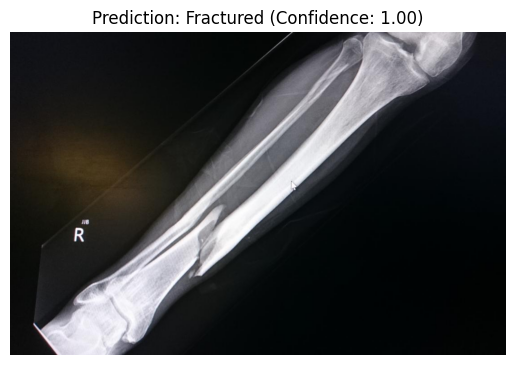

In [ ]:
import matplotlib.pyplot as plt


img = image.load_img(uploaded_image_path)
plt.imshow(img)
plt.title(f"Prediction: {prediction_label} (Confidence: {confidence:.2f})")
plt.axis('off')
plt.show()

In [ ]:
print(f"Number of Classes: {len(class_names)}")
print(f"Image shape: ({IMG_HEIGHT}, {IMG_WIDTH}, 1)") 
print(f"Epochs: {len(history.history['accuracy'])}") 
print(f"Batch size: {BATCH_SIZE}")

Number of Classes: 2
Image shape: (224, 224, 1)
Epochs: 30
Batch size: 32
